C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1056678691.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return p_z / np.trapz(p_z, z_grid)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1056678691.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return c_z / np.trapz(c_z, z_grid)


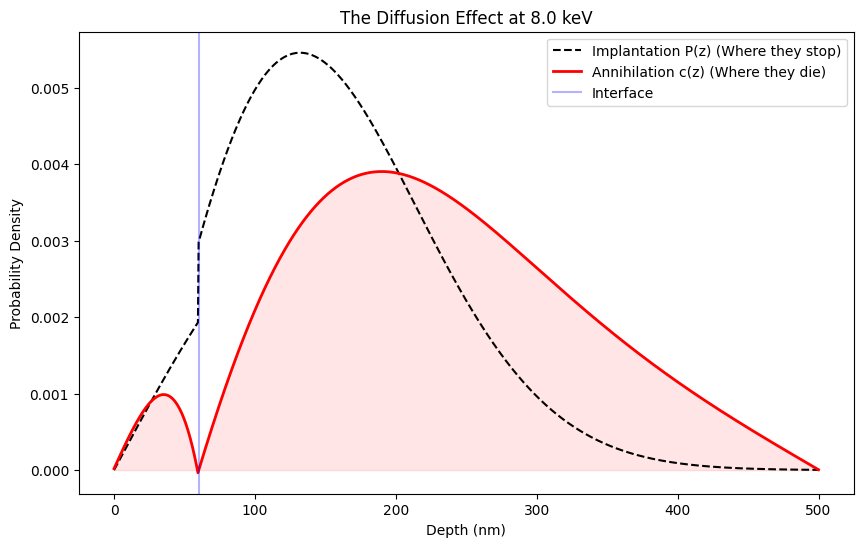

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# --- 1. Your Existing Implantation Logic ---
def makhov_profile(z_grid, energy_kev, layers):
    n, m, A = 1.6, 2.0, 4.0
    densities = np.zeros_like(z_grid)
    mass_depth = np.zeros_like(z_grid)
    current_z, accumulated_mass = 0, 0
    
    for layer in layers:
        mask = (z_grid >= current_z) & (z_grid <= current_z + layer['thickness'])
        densities[mask] = layer['density']
        mass_depth[mask] = accumulated_mass + (z_grid[mask] - current_z) * layer['density'] * 0.1
        accumulated_mass += layer['thickness'] * layer['density'] * 0.1
        current_z += layer['thickness']

    mean_xi = A * (energy_kev**n) 
    xi_0 = mean_xi / 0.886
    p_xi = (m * mass_depth**(m-1) / xi_0**m) * np.exp(-(mass_depth/xi_0)**m)
    p_z = p_xi * densities
    return p_z / np.trapz(p_z, z_grid)

# --- 2. The Diffusion Solver ---
def calculate_annihilation_profile(z_grid, p_z, layers):
    dz = z_grid[1] - z_grid[0]
    n_pts = len(z_grid)
    L_grid = np.zeros_like(z_grid)
    
    current_z = 0
    for layer in layers:
        mask = (z_grid >= current_z) & (z_grid <= current_z + layer['thickness'])
        # L+ is roughly 30nm in oxides, 150nm in annealed steel
        L_grid[mask] = 30 if 'Fe2O3' in layer['name'] else 150 
        current_z += layer['thickness']

    # Finite Difference Matrix: L^2 * (d2/dz2) - I
    main_diag = -2 * (L_grid**2 / dz**2) - 1
    off_diag = (L_grid[1:]**2 / dz**2)
    matrix = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(n_pts, n_pts)).tocsr()
    
    # Solve (matrix * c = -p_z)
    c_z = spsolve(matrix, -p_z)
    return c_z / np.trapz(c_z, z_grid)

# --- 3. Run and Plot ---
z = np.linspace(0, 500, 1000)
my_layers = [
    {'name': 'Fe2O3', 'thickness': 60, 'density': 5.22}, 
    {'name': 'SS316L', 'thickness': 1000, 'density': 8.00}
]

E = 8.0  # 8 keV beam
p_z = makhov_profile(z, E, my_layers)
c_z = calculate_annihilation_profile(z, p_z, my_layers)

plt.figure(figsize=(10, 6))
plt.plot(z, p_z, 'k--', label='Implantation P(z) (Where they stop)')
plt.plot(z, c_z, 'r-', lw=2, label='Annihilation c(z) (Where they die)')
plt.axvline(x=60, color='blue', alpha=0.3, label='Interface')
plt.fill_between(z, 0, c_z, color='red', alpha=0.1)
plt.title(f'The Diffusion Effect at {E} keV')
plt.xlabel('Depth (nm)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\3124796307.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return p_z / np.trapz(p_z, z_grid)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\3124796307.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return c_z / np.trapz(c_z, z_grid)


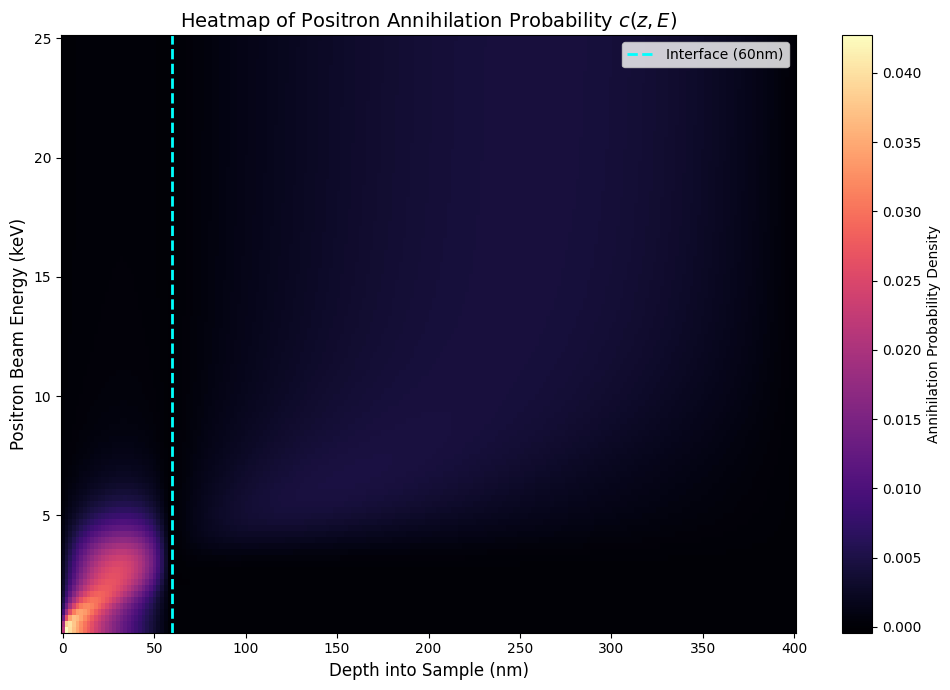

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# --- Physics functions remain the same ---
def makhov_profile(z_grid, energy_kev, layers):
    n, m, A = 1.6, 2.0, 4.0
    densities = np.zeros_like(z_grid); mass_depth = np.zeros_like(z_grid)
    curr_z, acc_mass = 0, 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        densities[mask] = l['density']
        mass_depth[mask] = acc_mass + (z_grid[mask] - curr_z) * l['density'] * 0.1
        acc_mass += l['thickness'] * l['density'] * 0.1
        curr_z += l['thickness']
    
    # Avoid division by zero at very low energy
    xi_0 = (A * max(energy_kev, 0.01)**n) / 0.886
    p_z = ((m * mass_depth**(m-1) / xi_0**m) * np.exp(-(mass_depth/xi_0)**m)) * densities
    return p_z / np.trapz(p_z, z_grid)

def calculate_annihilation_profile(z_grid, p_z, layers):
    dz = z_grid[1] - z_grid[0]
    L_grid = np.zeros_like(z_grid)
    curr_z = 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        # Diffusion length mapping
        L_grid[mask] = 30 if 'Fe' in l['name'] else 150 
        curr_z += l['thickness']
        
    main_diag = -2 * (L_grid**2 / dz**2) - 1
    off_diag = (L_grid[1:]**2 / dz**2)
    matrix = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(len(z_grid), len(z_grid))).tocsr()
    c_z = spsolve(matrix, -p_z)
    return c_z / np.trapz(c_z, z_grid)

# --- Heatmap Logic ---
z = np.linspace(0, 400, 200)
energies = np.linspace(0.2, 25, 100)
interface_depth = 60 # nm
my_layers = [{'name': 'Fe2O3', 'thickness': interface_depth, 'density': 5.22}, 
             {'name': 'SS316L', 'thickness': 1000, 'density': 8.00}]

# Initialize the 2D grid
annihilation_map = np.zeros((len(energies), len(z)))

for i, e_val in enumerate(energies):
    p_z = makhov_profile(z, e_val, my_layers)
    annihilation_map[i, :] = calculate_annihilation_profile(z, p_z, my_layers)

# --- Plotting ---
plt.figure(figsize=(10, 7))

# pcolormesh creates the heatmap. 'shading=auto' ensures grid alignment.
# 'magma' or 'viridis' are great for visibility.
heatmap = plt.pcolormesh(z, energies, annihilation_map, shading='auto', cmap='magma')

# Add a vertical line for the interface
plt.axvline(x=interface_depth, color='cyan', linestyle='--', linewidth=2, label='Interface (60nm)')

plt.colorbar(heatmap, label='Annihilation Probability Density')
plt.xlabel('Depth into Sample (nm)', fontsize=12)
plt.ylabel('Positron Beam Energy (keV)', fontsize=12)
plt.title('Heatmap of Positron Annihilation Probability $c(z, E)$', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1283617433.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return p_z / np.trapz(p_z, z_grid)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1283617433.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return c_z / np.trapz(c_z, z_grid)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1283617433.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s_e_curve.append(np.trapz(c_z * s_z, z))


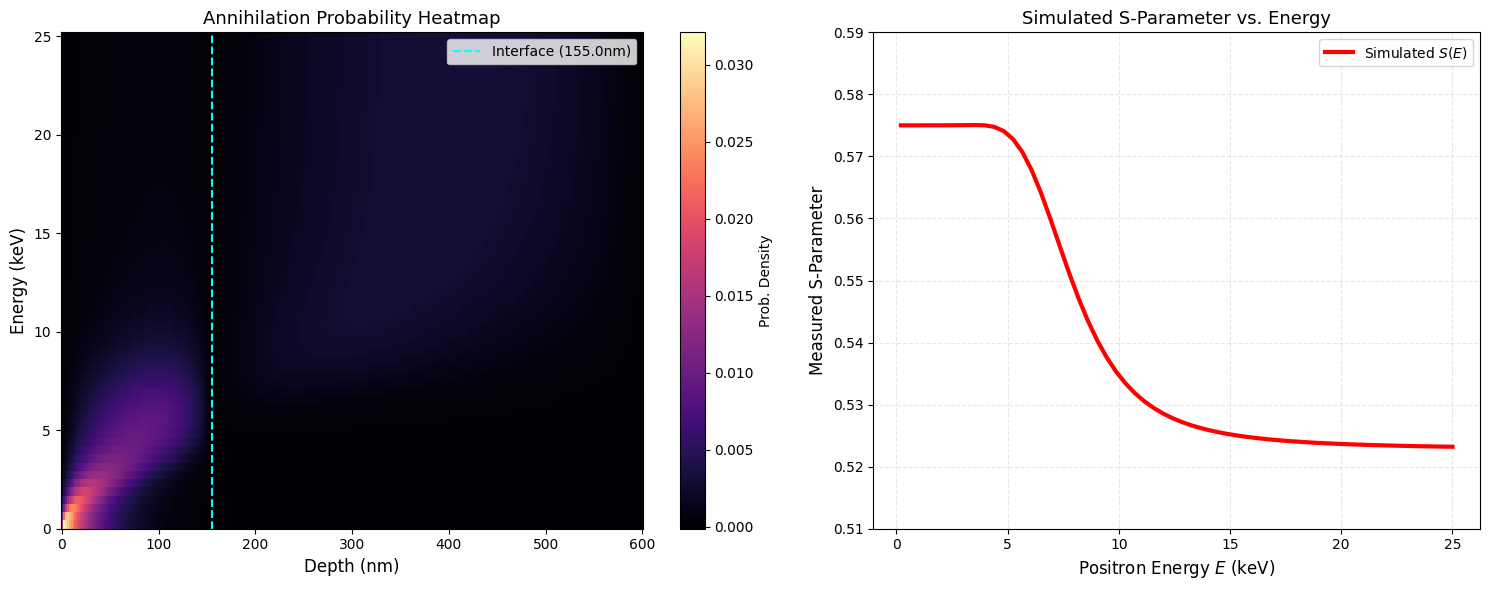

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# --- Physics Functions ---
def makhov_profile(z_grid, energy_kev, layers):
    n, m, A = 1.6, 2.0, 4.0
    densities = np.zeros_like(z_grid); mass_depth = np.zeros_like(z_grid)
    curr_z, acc_mass = 0, 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        densities[mask] = l['density']
        mass_depth[mask] = acc_mass + (z_grid[mask] - curr_z) * l['density'] * 0.1
        acc_mass += l['thickness'] * l['density'] * 0.1
        curr_z += l['thickness']
    xi_0 = (A * max(energy_kev, 0.01)**n) / 0.886
    p_z = ((m * mass_depth**(m-1) / xi_0**m) * np.exp(-(mass_depth/xi_0)**m)) * densities
    return p_z / np.trapz(p_z, z_grid)

def calculate_annihilation_profile(z_grid, p_z, layers):
    dz = z_grid[1] - z_grid[0]
    L_grid = np.zeros_like(z_grid)
    curr_z = 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        L_grid[mask] = l['L_diff']
        curr_z += l['thickness']
    matrix = diags([(L_grid[1:]**2/dz**2), -2*(L_grid**2/dz**2)-1, (L_grid[1:]**2/dz**2)], [-1, 0, 1], shape=(len(z_grid), len(z_grid))).tocsr()
    c_z = spsolve(matrix, -p_z)
    return c_z / np.trapz(c_z, z_grid)

# --- Parameters ---
d_ox = 155.0  # Fitted thickness
my_layers = [
    {'name': 'Fe2O3', 'thickness': d_ox, 'density': 5.22, 'L_diff': 30, 'S': 0.575},
    {'name': 'SS316L', 'thickness': 1000, 'density': 8.00, 'L_diff': 150, 'S': 0.520}
]

z = np.linspace(0, 600, 300)
energies = np.linspace(0.2, 25, 60)
prob_map = np.zeros((len(energies), len(z)))
s_e_curve = []

# Define S(z) Defect Map
s_z = np.where(z <= d_ox, 0.575, 0.520)

for i, e in enumerate(energies):
    p_z = makhov_profile(z, e, my_layers)
    c_z = calculate_annihilation_profile(z, p_z, my_layers)
    prob_map[i, :] = c_z
    # Calculate measured S as the weighted average
    s_e_curve.append(np.trapz(c_z * s_z, z))

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1.2, 1]})

# 1. Heatmap (Stays the same, providing context)
im = ax1.pcolormesh(z, energies, prob_map, shading='auto', cmap='magma')
ax1.axvline(d_ox, color='cyan', linestyle='--', label=f'Interface ({d_ox}nm)')
ax1.set_xlabel('Depth (nm)', fontsize=12)
ax1.set_ylabel('Energy (keV)', fontsize=12)
ax1.set_title('Annihilation Probability Heatmap', fontsize=13)
plt.colorbar(im, ax=ax1, label='Prob. Density')
ax1.legend()

# 2. Resulting S(E) Curve - FLIPPED AXES
ax2.plot(energies, s_e_curve, 'r-', lw=3, label='Simulated $S(E)$')
ax2.set_xlabel('Positron Energy $E$ (keV)', fontsize=12)
ax2.set_ylabel('Measured S-Parameter', fontsize=12)
ax2.set_title('Simulated S-Parameter vs. Energy', fontsize=13)
ax2.set_ylim(0.51, 0.59)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend()

plt.tight_layout()
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1355856329.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return p_z / np.trapz(p_z, z_grid)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1355856329.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return c_z / np.trapz(c_z, z_grid)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1355856329.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s_sharp_curve.append(np.trapz(c_z * s_z_sharp, z))
C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1355856329.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s_graded_curve.append(np.trapz(c_z * s_z_graded, z))


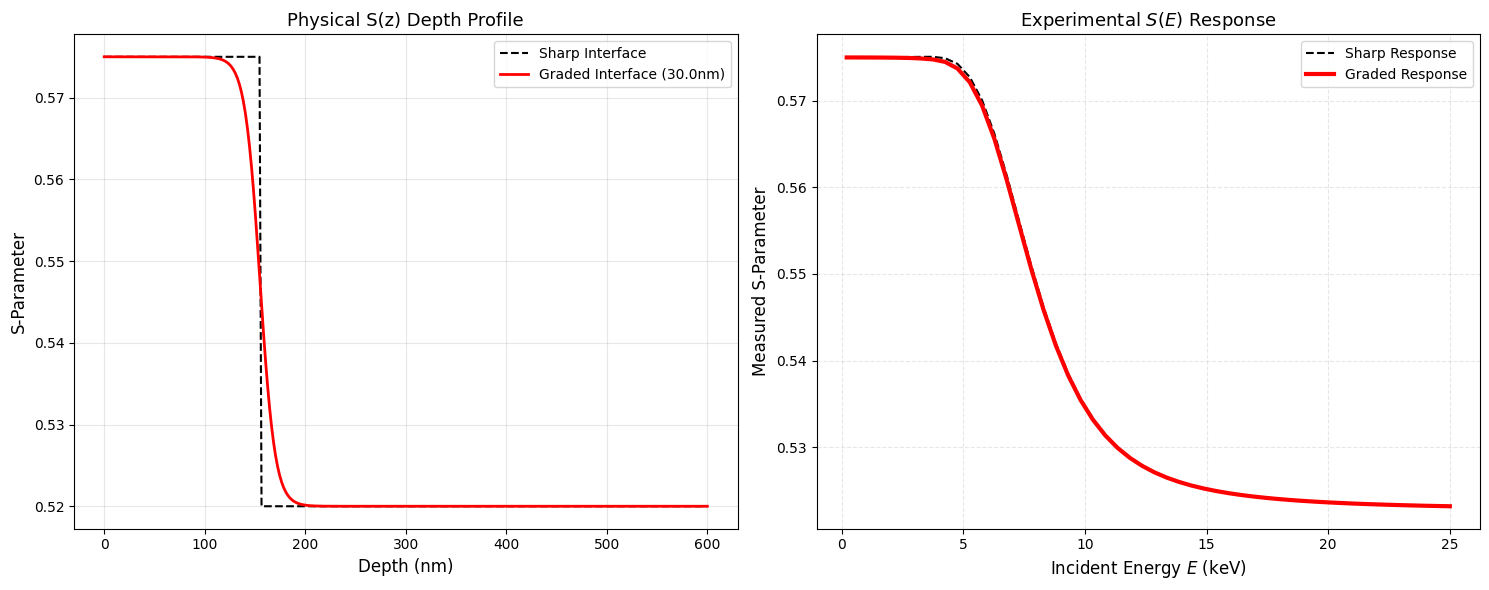

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# --- Physics Functions (Makhov + Diffusion) ---
def makhov_profile(z_grid, energy_kev, layers):
    n, m, A = 1.6, 2.0, 4.0
    densities = np.zeros_like(z_grid); mass_depth = np.zeros_like(z_grid)
    curr_z, acc_mass = 0, 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        densities[mask] = l['density']
        mass_depth[mask] = acc_mass + (z_grid[mask] - curr_z) * l['density'] * 0.1
        acc_mass += l['thickness'] * l['density'] * 0.1
        curr_z += l['thickness']
    xi_0 = (A * max(energy_kev, 0.01)**n) / 0.886
    p_z = ((m * mass_depth**(m-1) / xi_0**m) * np.exp(-(mass_depth/xi_0)**m)) * densities
    return p_z / np.trapz(p_z, z_grid)

def calculate_annihilation_profile(z_grid, p_z, layers):
    dz = z_grid[1] - z_grid[0]
    L_grid = np.zeros_like(z_grid)
    curr_z = 0
    for l in layers:
        mask = (z_grid >= curr_z) & (z_grid <= curr_z + l['thickness'])
        L_grid[mask] = l['L_diff']
        curr_z += l['thickness']
    matrix = diags([(L_grid[1:]**2/dz**2), -2*(L_grid**2/dz**2)-1, (L_grid[1:]**2/dz**2)], [-1, 0, 1], shape=(len(z_grid), len(z_grid))).tocsr()
    c_z = spsolve(matrix, -p_z)
    return c_z / np.trapz(c_z, z_grid)

# --- Simulation Parameters ---
d_ox = 155.0
w = 30.0 # Width of the transition zone in nm
my_layers = [
    {'name': 'Fe2O3', 'thickness': d_ox, 'density': 5.22, 'L_diff': 30, 'S_ox': 0.575},
    {'name': 'SS316L', 'thickness': 1000, 'density': 8.00, 'L_diff': 150, 'S_bulk': 0.520}
]

z = np.linspace(0, 600, 300)
energies = np.linspace(0.2, 25, 50)
s_sharp_curve = []
s_graded_curve = []

# --- Define S(z) Profiles (The Defect Map) ---
# Sharp interface at d_ox
s_z_sharp = np.where(z <= d_ox, 0.575, 0.520)
# Graded interface using a sigmoid transition
s_z_graded = 0.520 + (0.575 - 0.520) / (1 + np.exp((z - d_ox) / (w/4)))

# --- Execution ---
for e in energies:
    p_z = makhov_profile(z, e, my_layers)
    c_z = calculate_annihilation_profile(z, p_z, my_layers)
    s_sharp_curve.append(np.trapz(c_z * s_z_sharp, z))
    s_graded_curve.append(np.trapz(c_z * s_z_graded, z))

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: The physical S(z) profiles (Input Structure)
ax1.plot(z, s_z_sharp, 'k--', label='Sharp Interface')
ax1.plot(z, s_z_graded, 'r-', lw=2, label=f'Graded Interface ({w}nm)')
ax1.set_xlabel('Depth (nm)', fontsize=12)
ax1.set_ylabel('S-Parameter', fontsize=12)
ax1.set_title('Physical S(z) Depth Profile', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: The resulting S(E) curves (Experimental View)
# We swap 'energies' to the x-axis and 's_curves' to the y-axis
ax2.plot(energies, s_sharp_curve, 'k--', label='Sharp Response')
ax2.plot(energies, s_graded_curve, 'r-', lw=3, label='Graded Response')
ax2.set_xlabel('Incident Energy $E$ (keV)', fontsize=12)
ax2.set_ylabel('Measured S-Parameter', fontsize=12)
ax2.set_title('Experimental $S(E)$ Response', fontsize=13)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend()

plt.tight_layout()
plt.show()

In [33]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def simulate_pas_experiment(energies, layers, z_max=1000, steps=1000):
    z = np.linspace(0, z_max, steps)
    dz = z[1] - z[0]
    
    # Map properties to the z-grid
    L_grid = np.zeros_like(z)
    S_grid = np.zeros_like(z)
    current_depth = 0
    for layer in layers:
        mask = (z >= current_depth) & (z < current_depth + layer['thickness'])
        L_grid[mask] = layer['L_diff']
        S_grid[mask] = layer['S_bulk']
        current_depth += layer['thickness']

    simulated_S = []

    for E in energies:
        # 1. Get Implantation Profile P(z, E) from previous function
        p_z = makhov_profile(z, E, layers) 
        
        # 2. Solve Diffusion Equation: (L^2 * d2/dz2 - 1) * c = -P
        # Using finite difference matrix
        main_diag = -2 * (L_grid**2 / dz**2) - 1
        off_diag = (L_grid[1:]**2 / dz**2)
        matrix = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(steps, steps)).tocsr()
        
        # Solve for concentration c(z)
        c_z = spsolve(matrix, -p_z)
        
        # 3. Calculate observed S-parameter (weighted average)
        # S_obs = integral(c(z) * S_bulk) / integral(c(z))
        s_obs = np.trapezoid(c_z * S_grid, z) / np.trapezoid(c_z, z)
        simulated_S.append(s_obs)
        
    return energies, np.array(simulated_S)

# Example Parameters for Oxide on Steel
my_layers = [
    {'name': 'Fe2O3', 'thickness': 60, 'density': 5.24, 'L_diff': 30, 'S_bulk': 0.480},
    {'name': 'SS316L', 'thickness': 1000, 'density': 8.00, 'L_diff': 150, 'S_bulk': 0.450}
]

energies = np.linspace(0.5, 25, 40)
e, s_vals = simulate_pas_experiment(energies, my_layers)


C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\1283617433.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return p_z / np.trapz(p_z, z_grid)


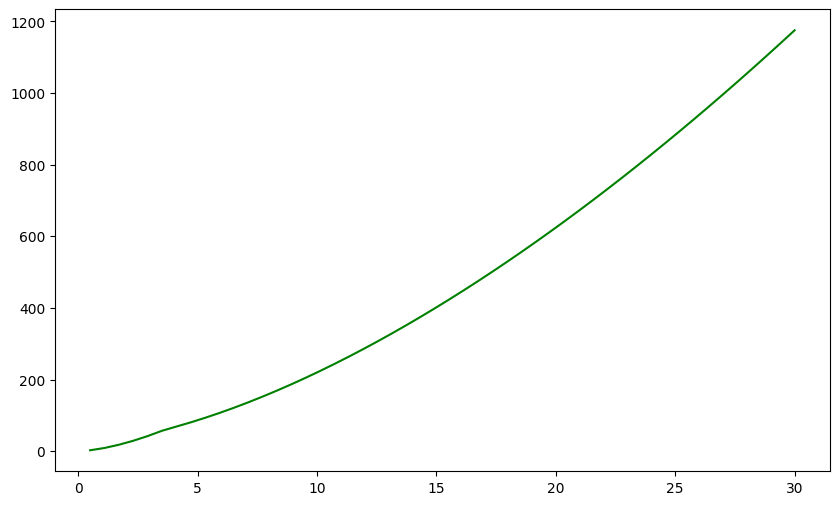

In [17]:
def energy_to_mean_depth(energies, d_ox, rho_ox, rho_sub):
    A = 4.0 # Using 4 in units of (ug/cm2 / keV^1.6)
    n = 1.6
    
    mean_depths = []
    for E in energies:
        mass_capacity = A * (E**n)
        oxide_mass_limit = (rho_ox * d_ox * 0.1) # 0.1 for unit conversion
        
        if mass_capacity <= oxide_mass_limit:
            # Entirely in oxide
            z_bar = mass_capacity / (rho_ox * 0.1)
        else:
            # Reaches steel
            remaining_mass = mass_capacity - oxide_mass_limit
            z_bar = d_ox + (remaining_mass / (rho_sub * 0.1))
            
        mean_depths.append(z_bar)
    return np.array(mean_depths)

# Example use:
e_range = np.linspace(0.5, 30, 50)
z_bar_range = energy_to_mean_depth(e_range, d_ox=60, rho_ox=5.24, rho_sub=8.0)


plt.figure(figsize=(10, 6))
plt.plot(e_range, z_bar_range, label='Mean Depth vs Energy', color='green')

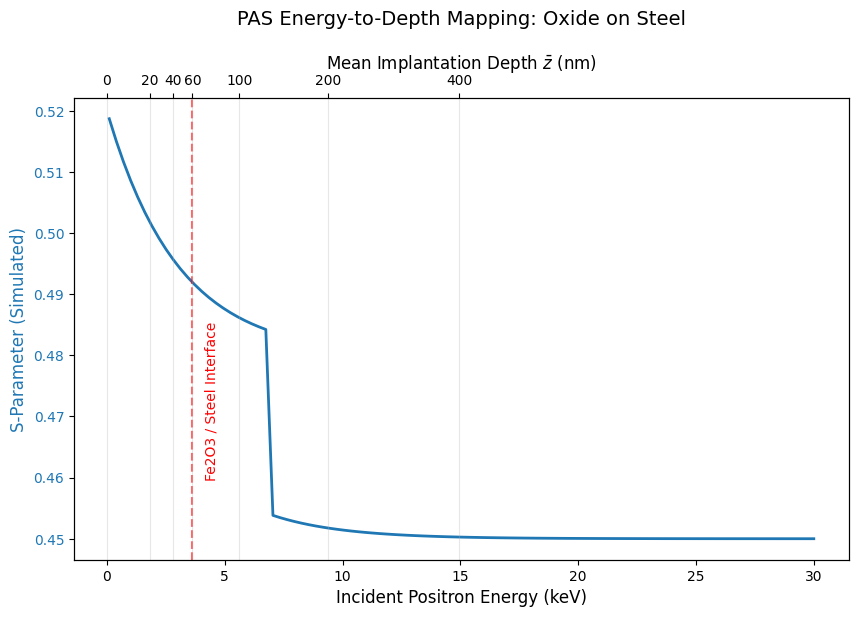

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants for your system
D_OX = 60.0      # Thickness of Fe2O3 in nm
RHO_OX = 5.24    # Density of Fe2O3
RHO_SS = 8.00    # Density of SS316L
A = 4.0          # Constant (approx 40 / 10 for nm conversion)
N = 1.6

def get_z_bar(E):
    """Calculates mean depth z_bar for a given Energy E"""
    mass_capacity = A * (E**N)
    oxide_mass_limit = RHO_OX * D_OX * 0.1 # unit normalization
    
    if mass_capacity <= oxide_mass_limit:
        return mass_capacity / (RHO_OX * 0.1)
    else:
        remaining = mass_capacity - oxide_mass_limit
        return D_OX + (remaining / (RHO_SS * 0.1))

# 1. Generate Data
energies = np.linspace(0.1, 30, 100)
depths = [get_z_bar(e) for e in energies]

# 2. Create the Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Axis: Energy
ax1.set_xlabel('Incident Positron Energy (keV)', fontsize=12)
ax1.set_ylabel('S-Parameter (Simulated)', color='tab:blue', fontsize=12)
# (Simulating a typical curve: Surface -> Oxide -> Steel)
s_sim = 0.52 - 0.04 * (1 - np.exp(-energies/3)) - 0.03 * (energies > 7) 
ax1.plot(energies, s_sim, color='tab:blue', lw=2, label='S(E) Curve')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary Axis: Depth
ax2 = ax1.twiny() # Create the top axis
ax2.set_xlabel('Mean Implantation Depth $\\bar{z}$ (nm)', fontsize=12)

# Set the ticks for the top axis by mapping specific depths back to energy
sample_depths = [0, 20, 40, 60, 100, 200, 400]
# We need an inverse function or a lookup to find the Energy for these Depths
tick_locations = []
for sd in sample_depths:
    # Inverse of our z_bar formula
    if sd <= D_OX:
        e_val = (sd * RHO_OX * 0.1 / A)**(1/N)
    else:
        e_val = ((D_OX * RHO_OX * 0.1 + (sd - D_OX) * RHO_SS * 0.1) / A)**(1/N)
    tick_locations.append(e_val)

ax2.set_xticks(tick_locations)
ax2.set_xticklabels([f"{d}" for d in sample_depths])
ax2.set_xlim(ax1.get_xlim())

# Highlight the Interface
interface_e = tick_locations[3] # Index of the 60nm tick
ax1.axvline(interface_e, color='red', linestyle='--', alpha=0.6)
ax1.text(interface_e+0.5, 0.46, 'Fe2O3 / Steel Interface', rotation=90, color='red')

plt.title('PAS Energy-to-Depth Mapping: Oxide on Steel', fontsize=14, pad=20)
plt.grid(alpha=0.3)
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_19288\508030266.py:11: RuntimeWarning: overflow encountered in exp
  return rho_ox + (rho_sub - rho_ox) / (1 + np.exp(-(z - d_ox) / (w/4)))


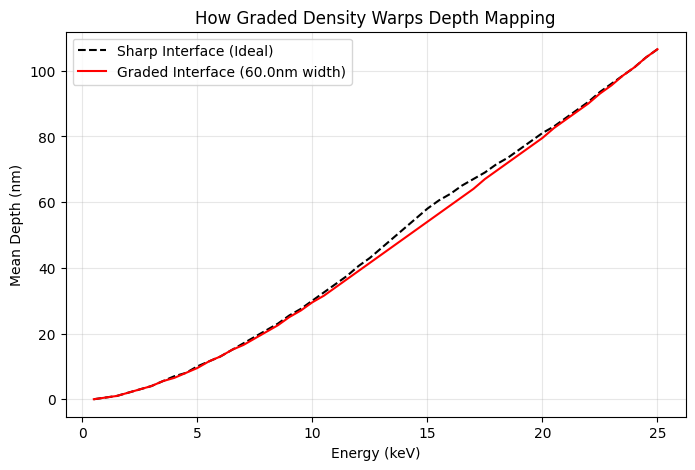

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def get_graded_density(z, d_ox, w, rho_ox, rho_sub):
    """
    Returns density at depth z using a sigmoid transition.
    d_ox: center of the transition (nominal thickness)
    w: width of the transition zone
    """
    # Sigmoid function to smooth the transition
    return rho_ox + (rho_sub - rho_ox) / (1 + np.exp(-(z - d_ox) / (w/4)))

def graded_mean_depth_finder(E, d_ox, w, rho_ox, rho_sub):
    """
    Finds the depth z where the accumulated mass matches the beam capacity.
    """
    A = 4.0
    N = 1.6
    target_mass = A * (E**N) * 0.1 # Normalized units
    
    # Numerical integration to find z
    z_fine = np.linspace(0, 1000, 2000)
    rho_z = get_graded_density(z_fine, d_ox, w, rho_ox, rho_sub)
    accumulated_mass = np.cumsum(rho_z * (z_fine[1] - z_fine[0]) * 0.1)
    
    # Find the index where we hit the target mass
    idx = np.searchsorted(accumulated_mass, target_mass)
    return z_fine[idx] if idx < len(z_fine) else z_fine[-1]

# Parameters
D_NOMINAL = 60.0    # 60nm oxide
TRANSITION_W = 60.0 # 20nm "blur" at the interface
RHO_OX = 5.24
RHO_SS = 8.00

energies = np.linspace(0.5, 25, 50)
z_graded = [graded_mean_depth_finder(e, D_NOMINAL, TRANSITION_W, RHO_OX, RHO_SS) for e in energies]
z_sharp = [graded_mean_depth_finder(e, D_NOMINAL, 0.1, RHO_OX, RHO_SS) for e in energies]

# Plotting the difference
plt.figure(figsize=(8, 5))
plt.plot(energies, z_sharp, 'k--', label='Sharp Interface (Ideal)')
plt.plot(energies, z_graded, 'r-', label=f'Graded Interface ({TRANSITION_W}nm width)')
plt.xlabel('Energy (keV)')
plt.ylabel('Mean Depth (nm)')
plt.title('How Graded Density Warps Depth Mapping')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()